# Interaction Analysis

In [1]:
import sys
sys.path.append("../src")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from maneuvers.interaction_detection import INTERACTION_FEATURES

In [3]:
m = 25
directory = "../data/events/interactions/"
bicycle_bicycle_path = directory + f"interactions-cyclist-cyclist-{m}m.csv"
bicycle_car_path = directory + f"interactions-cyclist-car-{m}m.csv"
bicycle_ped_path = directory + f"interactions-cyclist-pedestrian-{m}m.csv"

In [4]:
b_df = pd.read_csv(bicycle_bicycle_path)
df2 = b_df.copy()

df2["id_min"] = df2[["track_id", "other_id"]].min(axis=1)
df2["id_max"] = df2[["track_id", "other_id"]].max(axis=1)

df_unique = df2.drop_duplicates(subset=["id_min", "id_max"])
b_df_unique = df_unique.drop(columns=["id_min", "id_max"])

In [5]:
c_df = pd.read_csv(bicycle_car_path)
p_df = pd.read_csv(bicycle_ped_path)

In [6]:
features = INTERACTION_FEATURES[4:]
print("Interaction Features:\n", features)

Interaction Features:
 ('duration', 'dist_min', 'dist_mean', 'rel_speed', 'rel_heading', 'is_crossing')


## Analysis Functions

In [7]:
def filter_df(df, feature, min_val=None, max_val=None):
    result = df
    if min_val is not None:
        result = result[result[feature] >= min_val]
    if max_val is not None:
        result = result[result[feature] <= max_val]
    return result

In [8]:
def feature_distribution(dfs, labels, bins=30):
    # dfs: list of DataFrames
    # labels: list of names for legend
    n = len(features)

    fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=False)
    axes = axes.flatten()

    for ax, col in zip(axes, features):
        for df, lab in zip(dfs, labels):
            ax.hist(df[col], bins=bins, histtype="step", linewidth=1.5, label=lab, density=True)

        ax.set_title(col)
        ax.legend()

    for ax in axes[n:]:
        ax.set_visible(False)

    fig.tight_layout()
    return fig

def feature_distribution_box(dfs, labels):
    n = len(features)

    fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=False)
    axes = axes.flatten()

    for ax, col in zip(axes, features):
        data = [df[col].dropna() for df in dfs]
        ax.boxplot(data, tick_labels=labels, showmeans=True)
        ax.set_title(col)

    for ax in axes[n:]:
        ax.set_visible(False)

    fig.tight_layout()
    return fig


In [9]:
def feature_scatter(dfs, labels, x_feature, y_feature):
    fig, ax = plt.subplots(figsize=(12, 10))

    for df, label in zip(dfs, labels):
        ax.scatter(df[x_feature], df[y_feature], alpha=0.2, label=label, s=2)

    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.legend()
    ax.set_title(f"{y_feature} vs {x_feature}")
    return ax

## Analysis

### Interaction Frequency Analysis

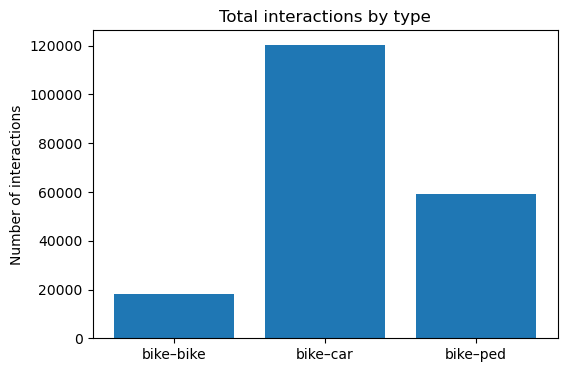

In [10]:
n_bb = b_df_unique.shape[0]
n_bc = c_df.shape[0]
n_bp = p_df.shape[0]
counts = {
    "bike–bike": n_bb,
    "bike–car": n_bc,
    "bike–ped": n_bp,
}

plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values())
plt.ylabel("Number of interactions")
plt.title("Total interactions by type")
plt.show()

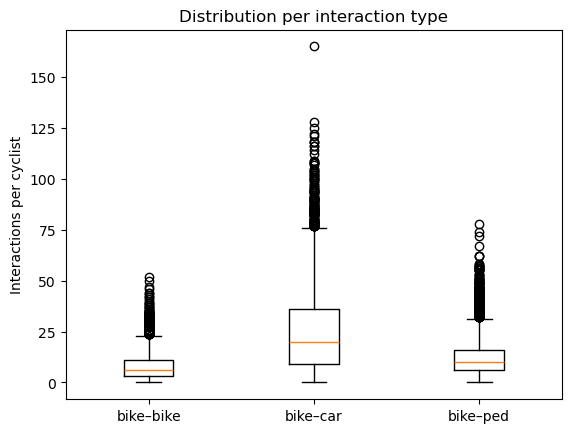

In [11]:
counts_bb = b_df["track_id"].value_counts()
counts_bc = c_df["track_id"].value_counts()
counts_bp = p_df["track_id"].value_counts()
interaction_counts = (
    pd.concat([
        counts_bb.rename("bike-bike"),
        counts_bc.rename("bike-car"),
        counts_bp.rename("bike-ped")
    ], axis=1)
    .fillna(0)
    .astype(int)
)

interaction_counts["total"] = interaction_counts.sum(axis=1)
interaction_counts.describe()

df = interaction_counts[["bike-bike", "bike-car", "bike-ped"]]

plt.boxplot([df["bike-bike"], df["bike-car"], df["bike-ped"]],
            tick_labels=["bike–bike", "bike–car", "bike–ped"])
plt.ylabel("Interactions per cyclist")
plt.title("Distribution per interaction type")
plt.show()


### Feature Analysis

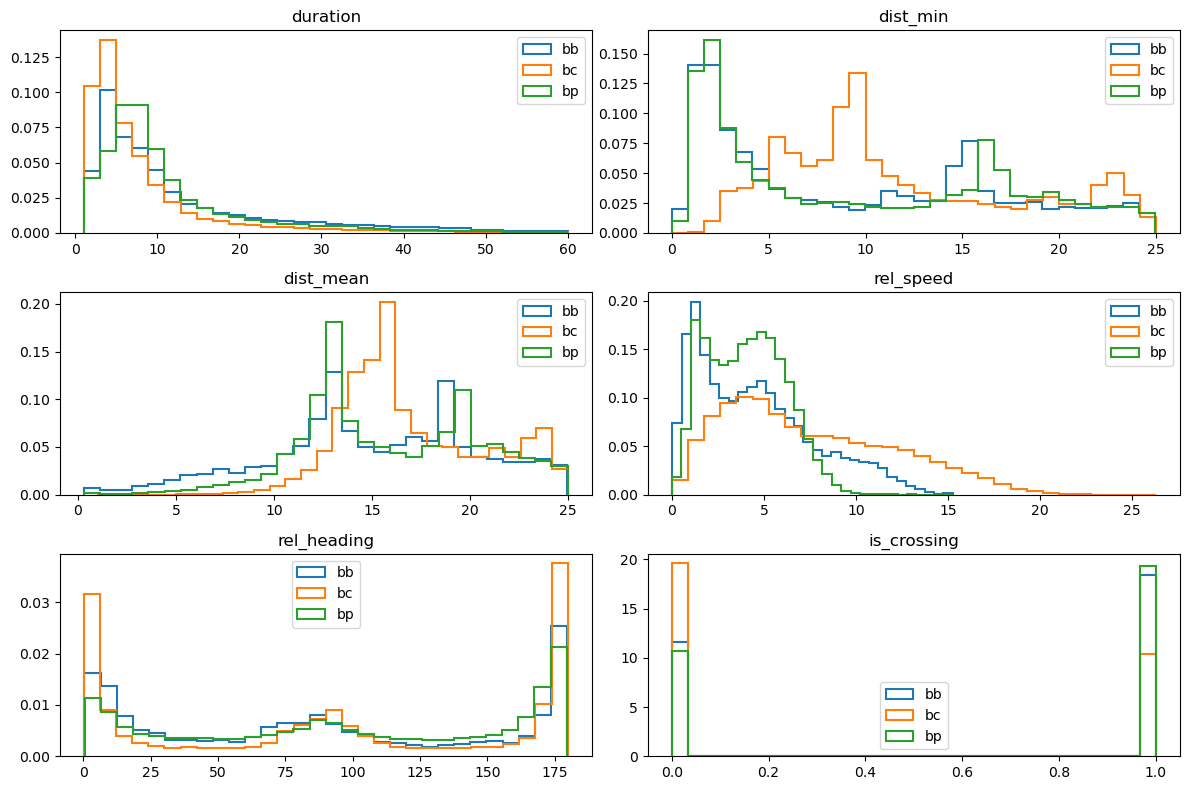

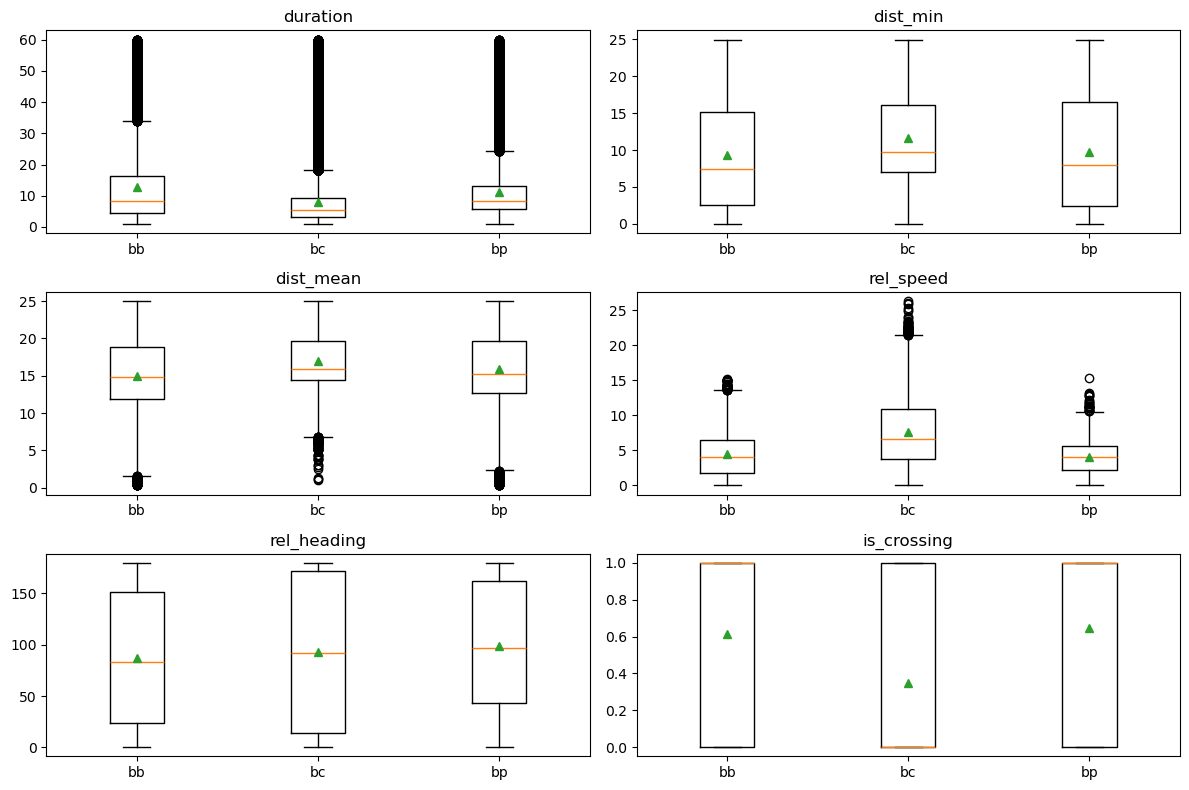

In [12]:
dfs_list = [b_df_unique, c_df, p_df]
labels = ["bb", "bc",  "bp"]
bins = 30

filters = {
    "dist_mean": {"min_val": 0.3, "max_val": 100},
    "duration": {"min_val": 1, "max_val": 60},
    
    #"rel_heading": {"max_val": 90}
}

filtered_dfs = []
for df in dfs_list:
    temp = df
    for feature, f in filters.items():
        temp = filter_df(temp, feature, **f)
    filtered_dfs.append(temp)

feature_distribution(filtered_dfs, labels, bins=bins)
feature_distribution_box(filtered_dfs, labels)
plt.show()

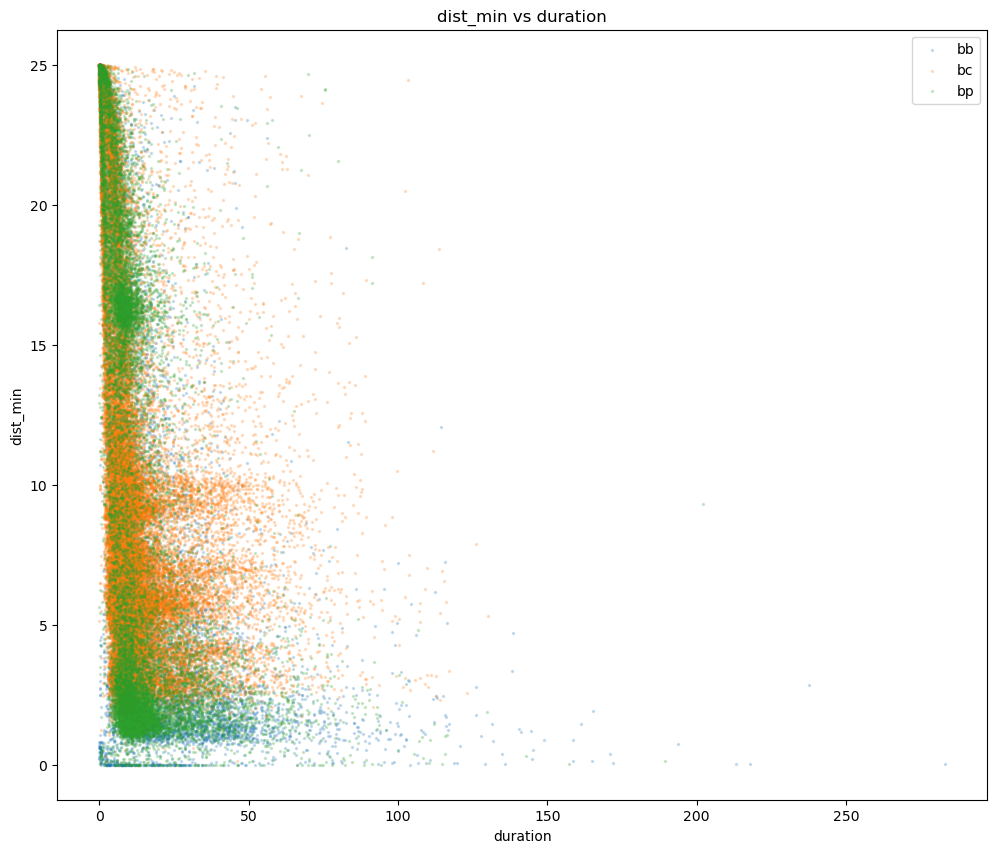

In [14]:
dfs_list = [b_df_unique, c_df, p_df]
labels = ["bb", "bc", "bp"]

filtered_dfs = []
filters = {
    "duration": {"min_val": 0},
    "rel_heading": {"max_val": 45}
}

for df in dfs_list:
    temp = df
    for feature, f in filters.items():
        temp = filter_df(temp, feature, **f)
    filtered_dfs.append(temp)

feature_scatter(filtered_dfs, labels, "duration", "dist_min")
plt.show()